In [ ]:
!pip install pyspark

In [ ]:
!pip install pyspark nltk regex

In [ ]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col, trim, lower, regexp_replace
from pyspark.sql.types import ArrayType, StringType, IntegerType
from pyspark.sql.functions import when
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, LinearSVC
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import re
import nltk
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [ ]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#Load data
!wget /content/training.1600000.processed.noemoticon.csv.zip
!unzip training.1600000.processed.noemoticon.csv.zip

/content/training.1600000.processed.noemoticon.csv.zip: Scheme missing.
Archive:  training.1600000.processed.noemoticon.csv.zip
  inflating: training.1600000.processed.noemoticon.csv  


In [ ]:
user_data = sc.textFile("/content/training.1600000.processed.noemoticon.csv")

#Split each row by comma
user_data_split = user_data.map(lambda line: line.split(","))

#Check a sample row
print(user_data_split.take(1))

#Convert to DataFrame with schema
#Dataset format: target, ids, date, flag, user, text
columns = ["target", "ids", "date", "flag", "user", "text"]

df = user_data_split.map(lambda row: (row[0], row[1], row[2], row[3], row[4], ",".join(row[5:])))\
              .toDF(columns)

#Show sample data
df.show(5, truncate=50)

#Check schema
df.printSchema()

[['"0"', '"1467810369"', '"Mon Apr 06 22:19:45 PDT 2009"', '"NO_QUERY"', '"_TheSpecialOne_"', '"@switchfoot http://twitpic.com/2y1zl - Awww', ' that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D"']]
+------+------------+------------------------------+----------+-----------------+--------------------------------------------------+
|target|         ids|                          date|      flag|             user|                                              text|
+------+------------+------------------------------+----------+-----------------+--------------------------------------------------+
|   "0"|"1467810369"|"Mon Apr 06 22:19:45 PDT 2009"|"NO_QUERY"|"_TheSpecialOne_"|"@switchfoot http://twitpic.com/2y1zl - Awww, t...|
|   "0"|"1467810672"|"Mon Apr 06 22:19:49 PDT 2009"|"NO_QUERY"|  "scotthamilton"|"is upset that he can't update his Facebook by ...|
|   "0"|"1467810917"|"Mon Apr 06 22:19:53 PDT 2009"|"NO_QUERY"|       "mattycus"|"@Kenichan I dived many times for 

In [ ]:
#data preprocessing

In [ ]:
#Distribution of original target column
df.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|   "0"|800000|
|   "4"|800000|
+------+------+



In [ ]:
df.select("target").distinct().rdd.map(lambda r: [r[0], [ord(c) for c in r[0]]]).collect()

[['"0"', [34, 48, 34]], ['"4"', [34, 52, 34]]]

In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def clean_text_raw(s: str) -> str:
    if s is None:
        return ""
    # 1. lower case
    text = s.lower()
    # 2. Remove URLs
    text = re.sub(r"http\S+|https?://\S+|www\.\S+", " ", text)
    # 3. Remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # 4. Remove user mentions @username
    text = re.sub(r"@\w+", " ", text)
    # 5. Remove hashtags (you can optionally keep the text)
    #    If you want to remove just the hash sign, keep the word:
    text = re.sub(r"#", "", text)
    # 6. Remove punctuation (non-alphanumeric except space)
    text = re.sub(r"[^a-zA-Z0-9\s]", " ", text)
    # 7. Remove numbers
    text = re.sub(r"\d+", " ", text)
    # 8. Remove extra whitespace
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize_and_lemmatize(s: str) -> list:
    #tokenize on whitespace
    tokens = s.split()
    #filter stopwords
    filtered = [t for t in tokens if t not in stop_words]
    #lemmatize
    lemmed = [lemmatizer.lemmatize(t) for t in filtered]
    return lemmed

#Define UDFs
clean_text_udf = udf(clean_text_raw, StringType())
tokenize_udf = udf(tokenize_and_lemmatize, ArrayType(StringType()))

#Apply preprocessing
df_clean = df.withColumn("text_clean", clean_text_udf(col("text")))

df_tokens = df_clean.withColumn("tokens", tokenize_udf(col("text_clean")))

df_final = (
    df_tokens
    .withColumn("label", regexp_replace(col("target"), "[^0-9]", "").cast("int"))
    .drop("target")
    .withColumn("label", when(col("label") == 4, 1).otherwise(0))  # map 4→1, keep 0→0
)

df_final.select("label").distinct().show()


#Show results
df_final.select("text", "text_clean", "tokens", "label").show(5, truncate=100)

#Split into train/test
train_df, test_df = df_final.randomSplit([0.8, 0.2], seed=42)

+-----+
|label|
+-----+
|    0|
|    1|
+-----+

+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+-----+
|                                                                                                text|                                                                                          text_clean|                                                                           tokens|label|
+----------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------+-----+
|"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You should

In [ ]:
df_final.groupBy("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|800000|
|    1|800000|
+-----+------+



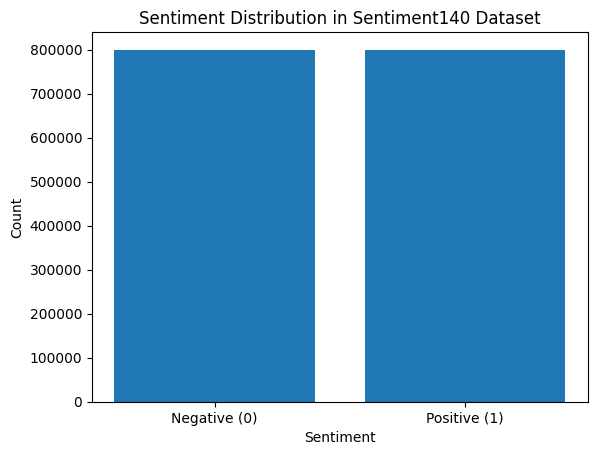

In [ ]:
#Collect target distribution into pandas for plotting
target_dist = df_final.groupBy("label").count().toPandas()

#Plot
plt.bar(target_dist['label'], target_dist['count'])
plt.xticks([0, 1], ["Negative (0)", "Positive (1)"])
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution in Sentiment140 Dataset")
plt.show()

In [ ]:
#Step 1: Tokenize (if not already tokenized)
tokenizer = Tokenizer(inputCol="text_clean", outputCol="words")

#Step 2: Remove stopwords
remover = StopWordsRemover(inputCol="words", outputCol="filtered")

#Step 3: TF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=20000)

#Step 4: IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

#Step 5: Models
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)
nb = NaiveBayes(featuresCol="features", labelCol="label", modelType="multinomial")
svm = LinearSVC(featuresCol="features", labelCol="label", maxIter=20)

#Step 6: Pipeline
pipeline_lr = Pipeline(stages=[tokenizer, remover, hashingTF, idf, lr])
pipeline_nb = Pipeline(stages=[tokenizer, remover, hashingTF, idf, nb])
pipeline_svm = Pipeline(stages=[tokenizer, remover, hashingTF, idf, svm])

In [ ]:
# ---------------------------------------
# Logistic Regression
# ---------------------------------------

model_lr = pipeline_lr.fit(train_df)
predictions_lr = model_lr.transform(test_df)

In [ ]:
# Evaluate
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
acc_lr = evaluator.evaluate(predictions_lr)
print("Logistic Regression Accuracy:", acc_lr)

Logistic Regression Accuracy: 0.765093163432064


In [ ]:
# ---------------------------------------
# Naive Bayes
# ---------------------------------------
model_nb = pipeline_nb.fit(train_df)
predictions_nb = model_nb.transform(test_df)
acc_nb = evaluator.evaluate(predictions_nb)
print("Naive Bayes Accuracy:", acc_nb)

Naive Bayes Accuracy: 0.7483603048473733


In [ ]:
# ---------------------------------------
# Support Vector Machine
# ---------------------------------------
model_svm = pipeline_svm.fit(train_df)
predictions_svm = model_svm.transform(test_df)
acc_svm = evaluator.evaluate(predictions_svm)
print("SVM Accuracy:", acc_svm)

SVM Accuracy: 0.7644682200675563


In [ ]:
# Show sample predictions
predictions_lr.select("text", "label", "prediction", "probability").show(10, truncate=80)

+--------------------------------------------------------------------------------+-----+----------+-----------------------------------------+
|                                                                            text|label|prediction|                              probability|
+--------------------------------------------------------------------------------+-----+----------+-----------------------------------------+
|"@Kenichan I dived many times for the ball. Managed to save 50%  The rest go ...|    0|       0.0|  [0.5590614068596891,0.4409385931403109]|
|                                                                   "Need a hug "|    0|       0.0|  [0.6374643353816358,0.3625356646183642]|
|                                          "@Tatiana_K nope they didn't have it "|    0|       0.0| [0.7372979034710772,0.26270209652892285]|
| "@octolinz16 It it counts, idk why I did either. you never talk to me anymore "|    0|       0.0| [0.9222075945478526,0.07779240545214738]|
|"@Fak